In [25]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

porter = nltk.PorterStemmer()

% matplotlib inline
sns.set(style="white", color_codes=True)
stop = stopwords.words('english')
dir = 'C:\\Users\\Travis Park\\Google Drive\\UN\\Team MOZART RAP\\'

In [2]:
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 
def TFIDFtotable(inputlist1, inputlist2, newcollist):
    corpus = inputlist1 + inputlist2
    
    x = tfidfvectorizer.fit_transform(corpus)
    x = pd.DataFrame((x * x.T).A)
    
    x = x.ix[:len(inputlist1)-1,len(inputlist1):]
    x.columns = newcollist
    x['Text'] = trimtext
    x = pd.merge(x, Paragraph_DF, how = 'left', left_on = 'Text', right_on = 'StemText')
    x=x.drop(['Text_x','Text_y','TrimText','StemText'],1)
    x=pd.melt(x, id_vars=['Number'])
    x.rename(columns={'Number':'Paragraph','variable': 'Target','value':'T_Cosine'}, inplace = True)
    TFIDFTable = x    
   
    return TFIDFTable

In [3]:
def RemoveVerbs(string):
    if len(string) > 0:
        x = nltk.pos_tag(string.split(' '))
        x = [(word, tag) for (word, tag) in x
             if tag.startswith('N') 
             or tag.startswith('J')
             or tag.startswith('R')]
        x = ' '.join([i[0] for i in x])
        return x
    else:
        return 'x x'

In [4]:
SDG_Targets = pd.read_excel(dir +'SDG goalsTrav.xlsx', names = ['ID', 'Goal','OrigionalText','GoalText'],sheetname = 'Sheet1')
SDG_Targets['TrimGoal'] = ''

targtext = []
x=0

while x < len(SDG_Targets):
    y = SDG_Targets['GoalText'][x].lower().replace('-',' ').split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    targtext.append(' '.join(y))
    x=x+1
    
SDG_Targets['TrimGoal'] = targtext

SDG_Targets.head(1)

,ID,Goal,OrigionalText,GoalText,TrimGoal
0,1,Poverty,Poverty End poverty in all its forms everywhere,poverty forms eveywhere,poverty forms eveywhere


In [5]:
f = open(dir + 'Bhutan_Doc_test.txt', 'r')
f = f.read().replace('. \n\n','.\n\n').replace('-',' ').replace('\x0c',' ').replace('...','').split('.\n\n')
f = [w.replace('\n',' ') for w in f]

w=0
wlist=[]
while w<len(f):
    wlist.append(w)
    w=w+1

In [6]:
Paragraph_DF = pd.DataFrame(columns = ['Number','Text', 'TrimText'])
Paragraph_DF['Number'] = wlist
Paragraph_DF['Text'] = f

In [7]:
ttext = []
x = 0 
while x < len(Paragraph_DF):
    y = Paragraph_DF['Text'][x].lower().split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    y = RemoveVerbs(' '.join(y))
    ttext.append(y)
    x=x+1
    
Paragraph_DF['TrimText'] = ttext

In [8]:
stemtext = []
x = 0
while x<len(Paragraph_DF):
    y = Paragraph_DF['TrimText'][x].split(' ')
    y = ' '.join([porter.stem(z) for z in y])
    stemtext.append(y)
    x=x+1
    
Paragraph_DF['StemText'] = stemtext

In [9]:
Paragraph_DF.head(1)

,Number,Text,TrimText,StemText
0,0,Eleventh Five Year Plan Main Document Volume...,eleventh year plan main document volume eleven...,eleventh year plan main document volum elevent...


In [10]:
alldocs = ttext+targtext

In [12]:
stuff = "ngram_range = (1,2),sublinear_tf=False, min_df = 0.01, max_features = 1100"
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 

x = tfidfvectorizer.fit_transform(alldocs)
y = pd.DataFrame((x * x.T).A)

z = y.ix[:len(ttext)-1,len(ttext):]
z.columns = list(SDG_Targets['ID'])

z1=z.unstack().reset_index()
z1.columns = ['Goal','Paragraph','CosineSimilarity']
z2 = z1[(z1['Goal'] != z1['Paragraph']) & (z1['CosineSimilarity'] > 0)]

z2.sort_values(by = 'CosineSimilarity', ascending = False).head()

avg = z2['CosineSimilarity'].mean()

a=a+1

avg

0.07929226990936537

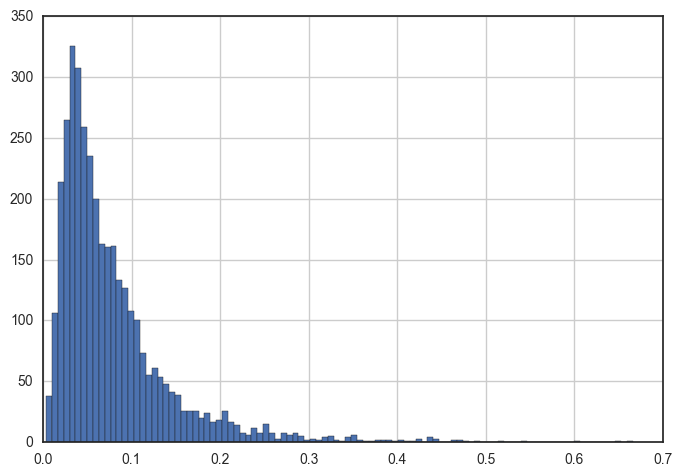

In [13]:
z2['CosineSimilarity'].hist(bins = 100);

In [14]:
z2.sort(['CosineSimilarity'], ascending = False).head(1)

C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Goal,Paragraph,CosineSimilarity
13496,13,116,0.666021


In [15]:
z3 = pd.pivot_table(z2, values = 'CosineSimilarity',index = 'Paragraph', aggfunc = 'max').reset_index()

z4 = pd.merge(z3, z2, how = 'left', left_on = ['Paragraph','CosineSimilarity'], right_on = ['Paragraph','CosineSimilarity'])
z4 = pd.merge(z4, Paragraph_DF, how = 'left', left_on = 'Paragraph', right_on = 'Number')
z4 = pd.merge(z4, SDG_Targets, how = 'left', left_on = 'Goal', right_on = 'ID')
z4 = z4.drop(['Number','ID','Goal_y'],1)
z4.rename(columns={'Goal_x': 'Goal'}, inplace = True)
z4 = z4[(z4['TrimText'].str.len() > 100)]

In [16]:
z4.to_csv(dir + 'rebuild.csv')

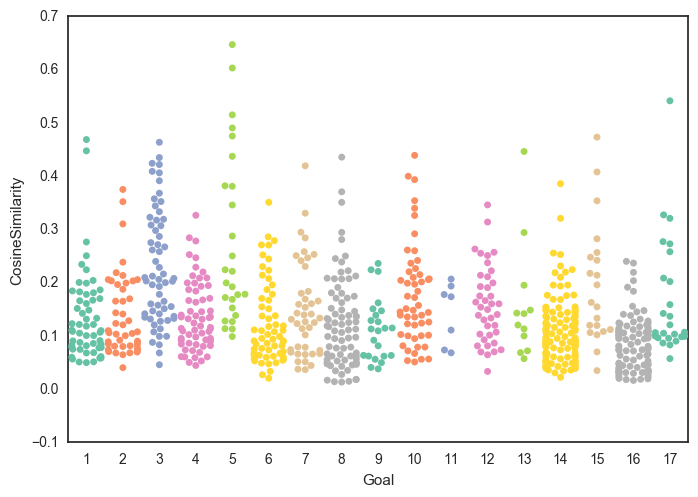

In [17]:
plt = sns.swarmplot(x="Goal", y="CosineSimilarity", data=z4, size = 5, edgecolor = 'w', palette = 'Set2');

In [18]:
SubTargets = pd.read_excel(dir +'SDG_test.xlsx', names = ['ID','GoalID','Target'],sheetname = 'Sheet2')
SubTargets['TrimTarget'] = ''
SubTargets['StemTarget'] = ''

In [19]:
stargtext = []
x=0

while x < len(SubTargets):
    y = SubTargets['Target'][x].lower().replace('-',' ').split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    if len(y)<1:
        y = 'x'
    y = RemoveVerbs(' '.join(y))
    stargtext.append(y)
    x=x+1
    
SubTargets['TrimTarget'] = stargtext

In [20]:
stemstargtext = []
x=0

while x < len(SubTargets):
    y = SubTargets['TrimTarget'][x].split(' ')
    y = ' '.join([porter.stem(z) for z in y])
    stemstargtext.append(y)
    x=x+1
    
SubTargets['StemTarget'] = stemstargtext

In [21]:
SubTargets.head(1)

,ID,GoalID,Target,TrimTarget,StemTarget
0,1.1,1,"By 2030, eradicate extreme poverty for all peo...",eradicate extreme poverty people currently peo...,erad extrem poverti peopl current peopl less


In [22]:
subtargets = list(SDG_Targets['ID'])
SubGoal_Match =pd.DataFrame(columns = ['Goal','Target','Paragraph','T_Cosine'])

y = 1
                                       
while y < len(subtargets)+1:
    z5 = z4[(z4['Goal'] == y)]
    SubTargets1 = SubTargets[(SubTargets['GoalID'] == y)]
    trimtext = list(z5['StemText'])
    trimstarget = list(SubTargets1['StemTarget'])
    newcolumns = list(SubTargets1['ID'])
    
    t = TFIDFtotable(trimtext, trimstarget, newcolumns)
    t['Goal'] = y
    
    frames = [SubGoal_Match, t]
    SubGoal_Match = pd.concat(frames)
    y=y+1

In [29]:
SubGoal_Max = pd.pivot_table(SubGoal_Match, values = 'T_Cosine',columns = 'Paragraph', aggfunc = 'max').reset_index()
SubGoal_Max = pd.merge(SubGoal_Max, SubGoal_Match, how = 'left', left_on = ['Paragraph','T_Cosine'], right_on = ['Paragraph','T_Cosine'])

SubGoal_Max = SubGoal_Max[(SubGoal_Max['T_Cosine'] > 0)] 
SubGoal_Max = pd.merge(SubGoal_Max, Paragraph_DF, how = 'left', left_on = 'Paragraph', right_on = 'Number')
SubGoal_Max = pd.merge(SubGoal_Max, SubTargets, how = 'left', left_on = 'Target', right_on = 'ID')
SubGoal_Max = SubGoal_Max.drop(['Number','GoalID','StemTarget','ID'],1)
SubGoal_Max.rename(columns={'Target_x': 'Target',
                              'Text':'PText',
                              'TrimText':'PTrimText',
                              'Target_y':'TargetText'}, inplace = True)
SubGoal_Max['Target'] = SubGoal_Max['Target'].astype(float)
SubGoal_Max['Goal'] = SubGoal_Max['Goal'].astype(float)
SubGoal_Max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 9 columns):
Paragraph     916 non-null float64
T_Cosine      916 non-null float64
Goal          916 non-null float64
Target        916 non-null float64
PText         916 non-null object
PTrimText     916 non-null object
StemText      916 non-null object
TargetText    916 non-null object
TrimTarget    916 non-null object
dtypes: float64(4), object(5)
memory usage: 71.6+ KB


In [30]:
SubGoal_Max.head(1)

,Paragraph,T_Cosine,Goal,Target,PText,PTrimText,StemText,TargetText,TrimTarget
0,0.0,0.050021,16.0,16.1,Eleventh Five Year Plan Main Document Volume...,eleventh year plan main document volume eleven...,eleventh year plan main document volum elevent...,Significantly reduce all forms of violence and...,significantly forms violence death rates


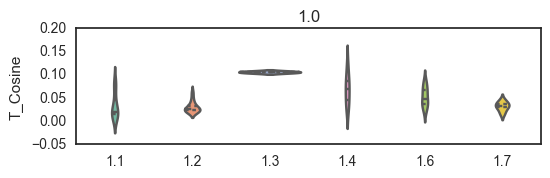

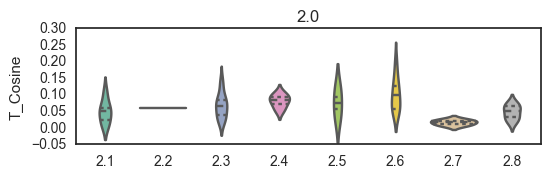

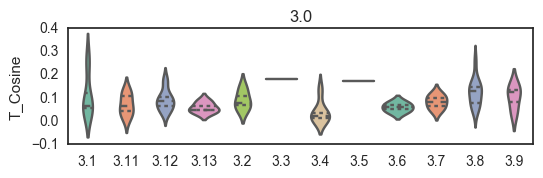

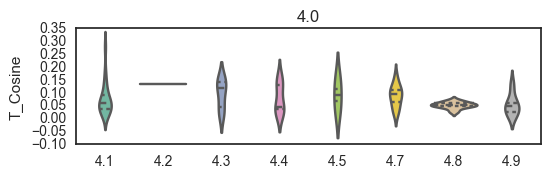

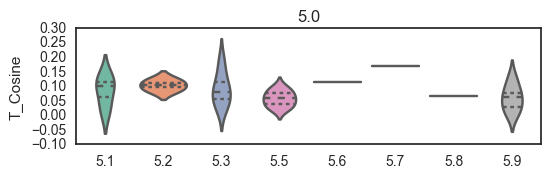

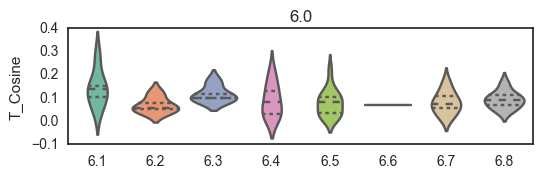

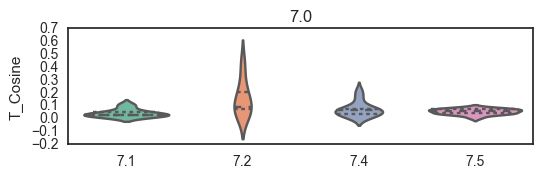

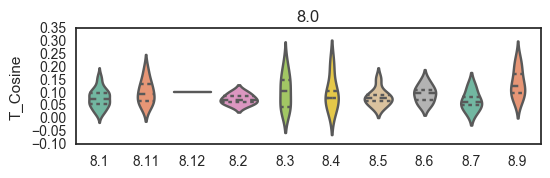

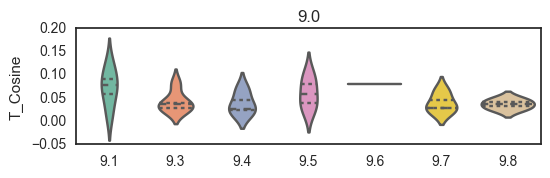

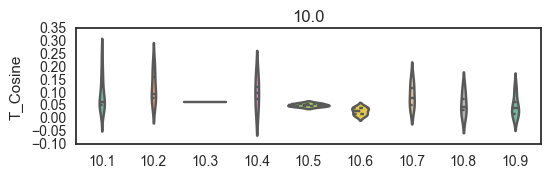

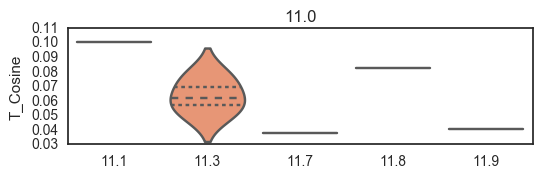

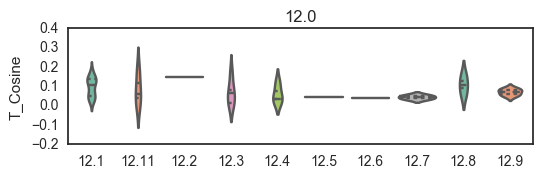

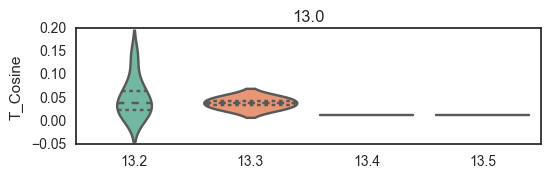

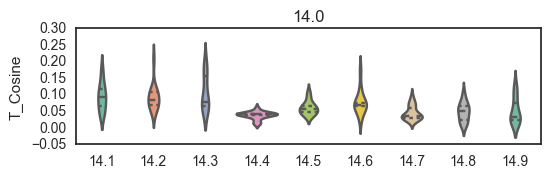

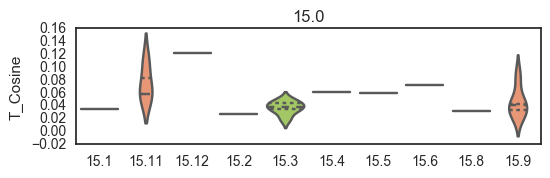

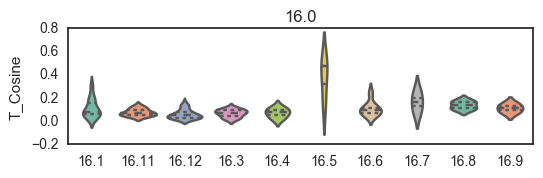

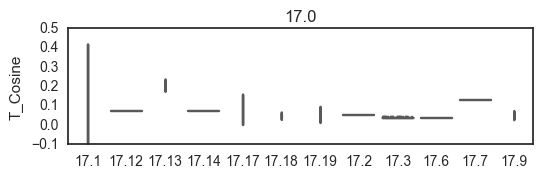

In [32]:
x = sorted(list(SubGoal_Max['Goal'].unique()))
y = sorted(list(SubGoal_Max['Target'].unique()))

for i in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,1.5))
    sns.violinplot(ax = ax, y = 'T_Cosine' , x = 'Target', palette = 'Set2', 
                data = SubGoal_Max[(SubGoal_Max['Goal'] == i)], size = 5, edgecolor = 'w',inner = 'quartile')
    plt.title(i)
    plt.xlabel('')

In [27]:
SubGoal_Max.to_csv(dir + 'target_assign.csv')